In [46]:
from datetime import datetime
import cv2 as cv
import numpy as np
import math
import mediapipe as mp
import os
import pandas as pd
import seaborn as sns

init recognizer

In [2]:
# !wget https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

CONFIDENCE = 0.25
# Create a hand landmarker instance with the video mode:
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2,
    min_tracking_confidence=CONFIDENCE,
    min_hand_presence_confidence=CONFIDENCE,
    min_hand_detection_confidence=CONFIDENCE)

load videos

In [27]:
def test_video(path):
    landmarker = HandLandmarker.create_from_options(options)

    cap = cv.VideoCapture(path)
    
    if not cap.isOpened():
        print("can't open file")
        exit(0)
        
    fps = cap.get(cv.CAP_PROP_FPS)
    print("fps", fps)
    
    frame_number = 0
    missing_count = 0
    data = []
    while True:
        ret, frame = cap.read()

        if not ret:
            break

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
        
        timestamp = int(1000 * frame_number / fps)
        frame_number += 1
        
        numpy_frame_from_opencv = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)
    
        result = landmarker.detect_for_video(mp_image, timestamp)
            
        if len(result.hand_landmarks) <= 1:
            # print("WARNING: no enough hand landmarks at", timestamp, len(result.hand_landmarks))
            missing_count += 1
            
        if len(result.hand_landmarks) == 0:
            continue

        hand = dict()
        hand['timestamp'] = timestamp
        hand['data'] = dict()
            
        for i, hand_landmarks in enumerate(result.hand_landmarks):
            side = result.handedness[i][0].category_name
            
            for j, point in enumerate(hand_landmarks):
                hand['data'][f"{side}_{j}_x"] = point.x
                hand['data'][f"{side}_{j}_y"] = point.y
                hand['data'][f"{side}_{j}_z"] = point.z
                hand['data'][f"{side}_{j}_visibility"] = point.visibility
                hand['data'][f"{side}_{j}_presence"] = point.presence
        
        data.append(hand)
        

    missing_ratio = missing_count / frame_number
    
    cap.release()
    cv.destroyAllWindows()
    
    return missing_ratio, data

In [ ]:
videos = []
for root, directories, files in os.walk('MXITESO100/'):
    for filename in files:
        videos.append(os.path.join(root, filename))

# expect 40 minutes
dataset = {'filename': [], 'score': [], 'data': []}
for video in videos:
    score, data = test_video(video)
    dataset['data'].append(data)
    dataset['filename'].append(video)
    dataset['score'].append(score)
    
dataset = pd.DataFrame(dataset)
dataset.to_json('data.json')

In [29]:
dataset.shape

(532, 3)

In [33]:
# find percentage of rows with score > 50%
useful = dataset[dataset['score'] > 0.5]
useful.to_json('useful.json')

In [42]:
words = set()
for i in useful['filename'].str.split('/'):
    words.add(i[1])
words

{'Abrir', 'Avión', 'Borrar', 'Encender', 'Mal', 'Niño', 'Zapato'}

sólo el 21% es útil

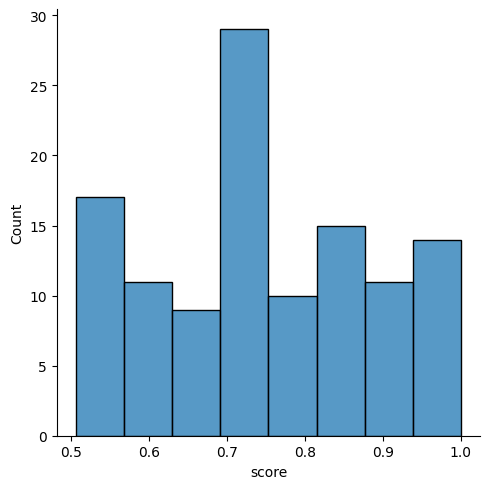

In [48]:
sns.displot(useful['score'])

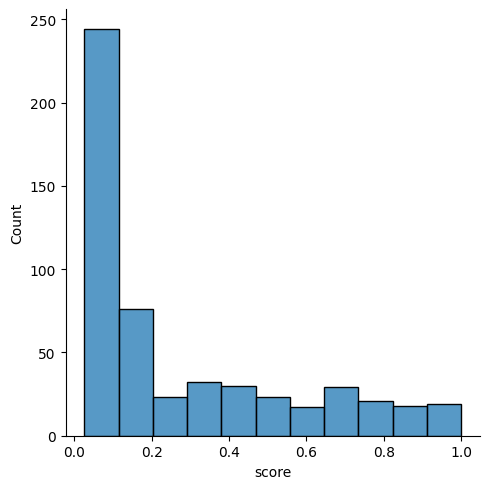

In [50]:
sns.displot(dataset['score'])